<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Random-preamble-stuff" data-toc-modified-id="Random-preamble-stuff-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Random preamble stuff</a></span></li><li><span><a href="#C-SAPR-data-download" data-toc-modified-id="C-SAPR-data-download-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>C-SAPR data download</a></span></li><li><span><a href="#Process-C-SAPR-data-(phase)" data-toc-modified-id="Process-C-SAPR-data-(phase)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Process C-SAPR data (phase)</a></span></li><li><span><a href="#Plot-figures,-including-NEXRAD-thing" data-toc-modified-id="Plot-figures,-including-NEXRAD-thing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plot figures, including NEXRAD thing</a></span><ul class="toc-item"><li><span><a href="#Do-main-plots-(run-this-after-4.2)" data-toc-modified-id="Do-main-plots-(run-this-after-4.2)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Do main plots (run this after 4.2)</a></span></li><li><span><a href="#Download-NEXRAD-(run-this-before-4.1)" data-toc-modified-id="Download-NEXRAD-(run-this-before-4.1)-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Download NEXRAD (run this before 4.1)</a></span></li></ul></li><li><span><a href="#Load-lightning-to-plot-with-RHIs-(incomplete)" data-toc-modified-id="Load-lightning-to-plot-with-RHIs-(incomplete)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load lightning to plot with RHIs (incomplete)</a></span></li></ul></div>

In [1]:
import glob
import os
from pathlib import Path
import act
import imageio as imageio
import matplotlib
import matplotlib.pyplot as plt
import pyart
from copy import deepcopy
import numpy as np
import cartopy.crs as ccrs
import cartopy
import shapely
import pyart
from tint.data_utils import get_nexrad_keys, read_nexrad_key
from tint import Cell_tracks, animate
from tint.visualization import embed_mp4_as_gif
import pandas as pd
from csu_radartools import (csu_fhc, csu_liquid_ice_mass, csu_blended_rain,csu_dsd, csu_kdp, csu_misc)
from shapely.geometry import Polygon, Point, MultiPoint
import warnings
import matplotlib.cm as cm
import pyart.graph.cm as pcm
from lmatools.io.LMA_h5_file import LMAh5File
from lmatools.coordinateSystems import RadarCoordinateSystem, GeographicSystem, TangentPlaneCartesianSystem, MapProjection
from dualpol import DualPolRetrieval # https://github.com/nasa/DualPol
from netCDF4 import Dataset
from pyproj import Geod
import sys
#sys.path.append("./LMAinterceptRHI/")
#sys.path.append("./TRACER-PAWS-NEXRAD-LMA/notebooks/LMAinterceptRHI/")
sys.path.append("/home/mvanlier/IPythonNBs/TRACER_ASR/TRACER-PAWS-NEXRAD-LMA/notebooks/LMAinterceptRHI/")
# Adapted functions from LMAinterceptRHI
from radarlma2local import geo_to_tps
from ortho_proj import rot_mat_lma, close_sources, closest_pt_radarloc
from radar_processing import r_z_centers_edges_mesh
from interp_funcs import centers_to_edges_1d, coords_2d
from datetime import datetime, date, time, timedelta
import xarray as xr



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
from datetime import datetime, date, time, timedelta


## Random preamble stuff

In [3]:
plt.rcParams['font.size'] = 14

In [4]:
import matplotlib.gridspec as gridspec

In [5]:
#define walkspace function
def walklevel(some_dir, level=1):
    some_dir = some_dir.rstrip(os.path.sep)
    assert os.path.isdir(some_dir)
    num_sep = some_dir.count(os.path.sep)
    for root, dirs, files in os.walk(some_dir):
        yield root, dirs, files
        num_sep_this = root.count(os.path.sep)
        if num_sep + level <= num_sep_this:
            #print('hello!')
            del dirs[:]

## C-SAPR data download

In [5]:
act.discovery.download_data?

In [6]:
username = "mvanlierwalq"
token   = "5b70d23c96777b14"

datastream = "houcsapr2cfrS2.a1"

#start_date = "2022-06-04T21:00:00"
#end_date   = "2022-06-04T21:20:00"
#startdate = "2022-06-17T19:00:00"
#enddate   = "2022-06-17T23:00:00"
startdate = "2022-08-07T18:30:00"
enddate   = "2022-08-07T20:00:00"

In [7]:
#..approximate metling level
melt_0604 = 4400/1000.
melt_0617 = 4830/1000.
melt_0807 = (4856+26)/1000.

In [8]:
#..Downlaod CSAPR data or just load in pre-existing filenames
brand_new = True
if brand_new:
    aug07_csapr_files = act.discovery.download_data(username,token,datastream,
                                                    startdate,enddate)
    numfiles = len(aug07_csapr_files)
else:
    basepath = './houcsapr2cfrS2.a1/'
    #basepath = '/home/marcus/marcus_data/ASR_TRACER_data/houscsapr2cfrS2_0604/'
    numfiles = 0
    filepre = 'houcsapr'
    aug07_csapr_files = []
    for root,dirs,files in walklevel(basepath,level=1):
        for file in files:
            if file.startswith(filepre): #change start with as string
                aug07_csapr_files.append(file)
                numfiles += 1
aug07_csapr_files = sorted(aug07_csapr_files)
print(numfiles)

[DOWNLOADING] houcsapr2cfrS2.a1.20220807.183755.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.184241.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.184144.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.184159.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.184344.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.184714.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.184854.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.184745.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.184800.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.185005.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.185734.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.190150.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.190224.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.190447.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.192653.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.193551.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.193624.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.193639.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.193710.nc
[DOWNLOADING] houcsapr2cfrS2.a1

[DOWNLOADING] houcsapr2cfrS2.a1.20220807.193250.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.193440.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.193350.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.193723.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.193809.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.193926.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.194303.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.194121.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.194319.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.194053.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.192326.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.192759.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.192834.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.193115.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.193305.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.194559.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.194459.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.194913.nc
[DOWNLOADING] houcsapr2cfrS2.a1.20220807.195158.nc
[DOWNLOADING] houcsapr2cfrS2.a1

NameError: name 'numfiles' is not defined

In [9]:
numfiles = len(aug07_csapr_files)

#numfiles = len(june17_csapr_files)
#

In [10]:
# !mkdir quicklooks/rhi
# !mkdir quicklooks/ppi
# !mkdir quicklooks/vpt
!mkdir quicklooks/sector

In [12]:
#..Plot quicklooks of CSAPR
#for file in june17_csapr_files:
for file in aug07_csapr_files:
    radar = pyart.io.read(file)
    #print(radar.scan_type)
    #print(file)
    if (radar.scan_type != 'other'):
        fig = plt.figure(figsize=(6, 4))
        ax = fig.add_subplot(111)
        display = pyart.graph.RadarDisplay(radar)
        display.plot("reflectivity", 0)
        fig.savefig(f"quicklooks/{radar.scan_type}/{Path(file).stem}.png", dpi=200)
        plt.close(fig)
        fig.clf()
    else:
        print('skipping:', file[-15:], ', type = ',radar.scan_type)

In [13]:
for i in range(numfiles):
    if not brand_new:
        #june17_csapr_files[i] = basepath+june17_csapr_files[i]
        aug07_csapr_files[i] = basepath+aug07_csapr_files[i]
    print(i,aug07_csapr_files[i])

0 /home/mvanlier/IPythonNBs/TRACER_ASR/houcsapr2cfrS2.a1/houcsapr2cfrS2.a1.20220807.183024.nc
1 /home/mvanlier/IPythonNBs/TRACER_ASR/houcsapr2cfrS2.a1/houcsapr2cfrS2.a1.20220807.183040.nc
2 /home/mvanlier/IPythonNBs/TRACER_ASR/houcsapr2cfrS2.a1/houcsapr2cfrS2.a1.20220807.183100.nc
3 /home/mvanlier/IPythonNBs/TRACER_ASR/houcsapr2cfrS2.a1/houcsapr2cfrS2.a1.20220807.183119.nc
4 /home/mvanlier/IPythonNBs/TRACER_ASR/houcsapr2cfrS2.a1/houcsapr2cfrS2.a1.20220807.183134.nc
5 /home/mvanlier/IPythonNBs/TRACER_ASR/houcsapr2cfrS2.a1/houcsapr2cfrS2.a1.20220807.183149.nc
6 /home/mvanlier/IPythonNBs/TRACER_ASR/houcsapr2cfrS2.a1/houcsapr2cfrS2.a1.20220807.183202.nc
7 /home/mvanlier/IPythonNBs/TRACER_ASR/houcsapr2cfrS2.a1/houcsapr2cfrS2.a1.20220807.183230.nc
8 /home/mvanlier/IPythonNBs/TRACER_ASR/houcsapr2cfrS2.a1/houcsapr2cfrS2.a1.20220807.183245.nc
9 /home/mvanlier/IPythonNBs/TRACER_ASR/houcsapr2cfrS2.a1/houcsapr2cfrS2.a1.20220807.183258.nc
10 /home/mvanlier/IPythonNBs/TRACER_ASR/houcsapr2cfrS2.a1/ho

In [15]:
#..Hand selected "sets" of RHIs named by (arbitrary) index in my directory. Original
#..integers refer to listing if you follow above directions for download of CSAPR
# offset = (1193-235)
# csapr_idx1 = [1194-offset,1196-offset,1199-offset,1200-offset,1201-offset,1204-offset,
#               1205-offset,1206-offset,1213-offset,1223-offset]
# csapr_idx2 = [1209-offset,1210-offset,1214-offset,1215-offset,1216-offset,1219-offset]
# csapr_idx3 = [393,]
csapr_idx1 = [229,230,234,235,236,237,240,242,244,246,247,249,251,252,254,256,259,261,266,271]
csapr_idx2 = [276,279,280,281,284,286,289,292,296,299,304,307,309,311,322]
csapr_idx3 = [2,4,9,11,17,19,23,24,25,26,30,31,32,33,38,40,45,47,52,54]

In [11]:
print(csapr_idx1)

[229, 230, 234, 235, 236, 237, 240, 242, 244, 246, 247, 249, 251, 252, 254, 256, 259, 261, 266, 271]


In [16]:
basepath = './houcsapr2cfrS2.a1/'

In [18]:
#print(june17_csapr_files[240][-36:])
print(aug07_csapr_files[23][-36:])

houcsapr2cfrS2.a1.20220807.183705.nc


## Process C-SAPR data (phase)

In [19]:
#..Process all data specified by index for downloaded files
#testpath = './csapr_test_0617/'
testpath = './houcsapr2cfrS2.a1_proc/'
ii = 0
#brand_new = True
if brand_new:
    for idx in csapr_idx3:
        #fname = june17_csapr_files[idx][-36:]
        fname = aug07_csapr_files[idx][-36:]
        radar = pyart.io.read(basepath+fname)
        retrieve = DualPolRetrieval(radar, gs=100.0, dz='reflectivity',
                              dr='differential_reflectivity',
                              #dr='RD',
                              dp='differential_phase',
                              rh='copol_correlation_coeff',
                              #fhc_T_factor=2, ice_flag=True,
                              #fhc_flag=False, ice_flag=False,dsd_flag=False,precip_flag=False,liquid_ice_flag=False,
                              fhc_flag=True, ice_flag=False,dsd_flag=True,precip_flag=True,liquid_ice_flag=False,
                              kdp_window=1.8, thresh_sdp=20.0, speckle=3,
                              #kdp_window=5, thresh_sdp=20.0, speckle=3,   #..prev
                              #kdp_window=5, thresh_sdp=20.0, speckle=10,
                              kdp_method='CSU',
                              rain_method='hidro',
                              qc_flag=True, verbose=False)
        print(testpath+fname[:-3] + '_proc.nc')
        pyart.io.write_cfradial(testpath+fname[:-3]+'_proc.nc', radar)
        ii += 1
else:
    pass

0.0149383544921875 seconds to run csu_kdp
No sounding provided
0.0213167667388916 seconds to do FHC
./houcsapr2cfrS2.a1_proc/houcsapr2cfrS2.a1.20220807.183100_proc.nc
0.01255488395690918 seconds to run csu_kdp
No sounding provided
0.015547752380371094 seconds to do FHC
./houcsapr2cfrS2.a1_proc/houcsapr2cfrS2.a1.20220807.183134_proc.nc
0.01284933090209961 seconds to run csu_kdp
No sounding provided
0.01650857925415039 seconds to do FHC
./houcsapr2cfrS2.a1_proc/houcsapr2cfrS2.a1.20220807.183258_proc.nc
0.013139724731445312 seconds to run csu_kdp
No sounding provided
0.0165102481842041 seconds to do FHC
./houcsapr2cfrS2.a1_proc/houcsapr2cfrS2.a1.20220807.183329_proc.nc
0.012659788131713867 seconds to run csu_kdp
No sounding provided
0.0171966552734375 seconds to do FHC
./houcsapr2cfrS2.a1_proc/houcsapr2cfrS2.a1.20220807.183514_proc.nc
0.012756586074829102 seconds to run csu_kdp
No sounding provided
0.017421960830688477 seconds to do FHC
./houcsapr2cfrS2.a1_proc/houcsapr2cfrS2.a1.20220807.

## Plot figures, including NEXRAD thing

In [20]:
#del keys
!mkdir KHGX

#keys = get_nexrad_keys('KHGX',start='20220604_210000',end='20220604_235000')
#keys = get_nexrad_keys('KHGX',start='20220617_190000',end='20220617_230000')
keys = get_nexrad_keys('KHGX',start='20220807_183000',end='20220807_200000')
brand_new=True
if brand_new:
    for key in keys:
        fname = os.path.split(str(key))[1][:-1]
        radar = read_nexrad_key(key)
        fnams = fname[0:4]+'_'+fname[-3:]+'_'+fname[4:8]+'_'+fname[8:12]+'_'+fname[13:19]+'.nc'
        pyart.io.write_cfradial('KHGX/'+fnams,radar)
else:
    for key in keys:
        fname = os.path.split(str(key))[1][:-1]
        fnams = fname[0:4]+'_'+fname[-3:]+'_'+fname[4:8]+'_'+fname[8:12]+'_'+fname[13:19]+'.nc'
brand_new=False

mkdir: cannot create directory 'KHGX': File exists
Found 14 keys.


In [18]:
print(int(fname[13:19]))

225855


In [21]:
#..Get times for each nexrad
khgx_times = []
for key in keys:
    fname = os.path.split(str(key))[1][:-1]
    khgx_times = np.r_[khgx_times,int(fname[13:19])]

In [22]:
print(khgx_times)

[183311. 183910. 184524. 185128. 185749. 190443. 191122. 191744. 192407.
 193030. 193645. 194253. 194901. 195508.]


In [23]:
print(testpath)
print(fname)

./houcsapr2cfrS2.a1_proc/
KHGX20220807_195508_V06


183720
(1, 183910.0)


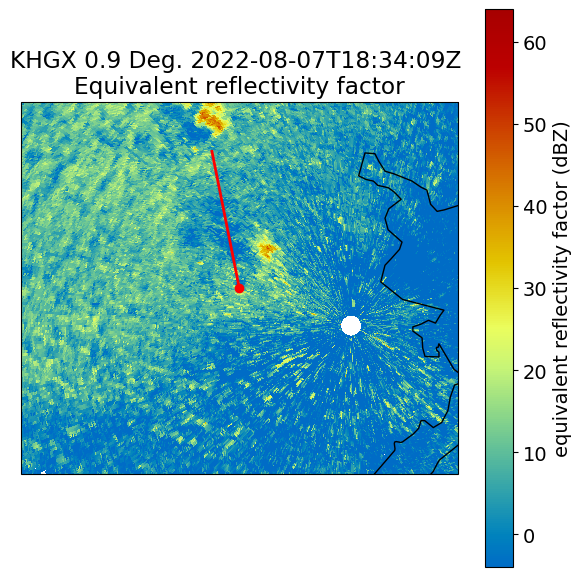

In [24]:
#..Test out plot of nexrad with line showing closest (after) CSAPR RHI direction
#idx = 242
#fname = june17_csapr_files[idx]
idx = 24
fname = aug07_csapr_files[idx]
numba = int(fname[-9:-3])
print(numba)
thing = min(enumerate(khgx_times), key=lambda x: abs(x[1]-numba))
print(thing)
if (thing[1]>numba):
    nexidx = thing[0]-1
else:
    nexidx = thing[0]
radar = pyart.io.read(testpath+fname[-36:-3]+'_proc.nc')
az = radar.azimuth['data'][0]
csapr_lat = radar.latitude['data'][0]
csapr_lon = radar.longitude['data'][0]
del radar
radar = read_nexrad_key(keys[nexidx])
display = pyart.graph.RadarMapDisplay(radar)

# Setting projection and ploting the second tilt
projection = ccrs.LambertConformal(central_latitude=csapr_lat,
                                   central_longitude=csapr_lon)
fig = plt.figure(figsize=(6,6))
lon_off = .4
lat_off = .3
display.plot_ppi_map('reflectivity', 2, vmin=-4, vmax=64,
                     min_lon=csapr_lon-lon_off, max_lon=csapr_lon+lon_off, 
                     min_lat=csapr_lat-lat_off, max_lat=csapr_lat+lat_off,
                     lon_lines=np.arange(-158, -154, .2), resolution='10m',
                     lat_lines=np.arange(69, 72, .1), projection=projection,
                     fig=fig, lat_0=csapr_lat,
                     lon_0=csapr_lon)

g = Geod(ellps='sphere')
lon = csapr_lon
lat = csapr_lat
rng = 1000 *25

lon2, lat2, _ = g.fwd(lon, lat, az, rng)
plt.plot([csapr_lon, lon2], [csapr_lat, lat2], transform=ccrs.Geodetic(),c='r',lw=2)
display.plot_point(csapr_lon, csapr_lat,c='r')
fig.patch.set_facecolor('white')
fig.tight_layout()

### Do main plots 

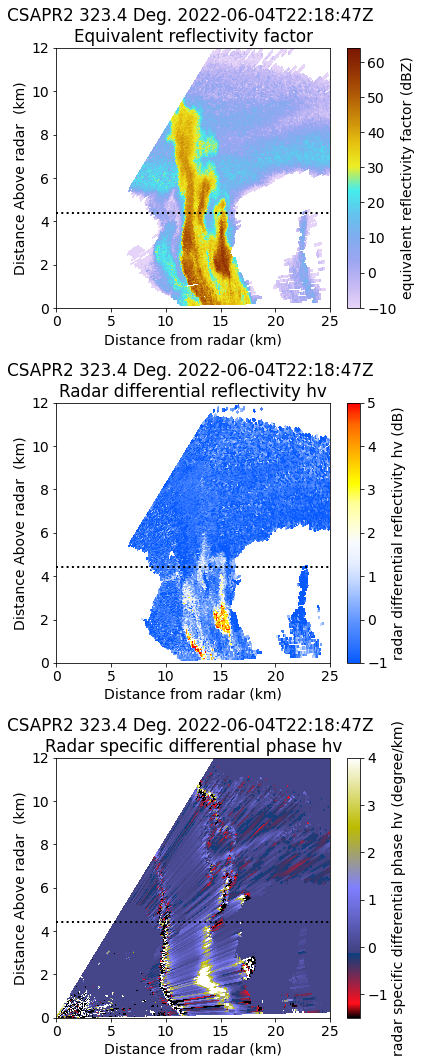

In [20]:
#...This is an example to test plotting
fname = june4_csapr_files[393]
radar = pyart.io.read(testpath+fname[:-3]+'_proc.nc')
#..
maxx = 25
maxz = 12
fig = plt.figure(figsize=(6, 15))
ax = fig.add_subplot(311)
display = pyart.graph.RadarDisplay(radar)
display.plot("reflectivity", 0,vmin=-10,vmax=64,cmap=pcm.LangRainbow12)
ax.plot([0,maxx],[melt_0604,melt_0604],'k:',lw=2)
ax.set_xlim(0,maxx)
ax.set_ylim(0,maxz)
#..
ax = fig.add_subplot(312)
display = pyart.graph.RadarDisplay(radar)
#display.plot("differential_reflectivity", 0)
#display.plot("differential_reflectivity",0,vmin=-1,vmax=5,
display.plot("attenuation_corrected_differential_reflectivity",0,vmin=-1,vmax=5,
             cmap=pcm.BuOrR14, mask_tuple=['reflectivity', -5.])
             #cmap=pcm.RefDiff)
             #cmap=pcm.RefDiff)
ax.plot([0,maxx],[melt_0604,melt_0604],'k:',lw=2)
ax.set_xlim(0,maxx)
ax.set_ylim(0,maxz)
#..
ax = fig.add_subplot(313)
display = pyart.graph.RadarDisplay(radar)
#display.plot("KDP_CSU", 0,vmin=-1.5,vmax=4.,cmap=cm.gist_stern)
display.plot("specific_differential_phase", 0,vmin=-1.5,vmax=4.,cmap=cm.gist_stern)
ax.plot([0,maxx],[melt_0604,melt_0604],'k:',lw=2)
ax.set_xlim(0,maxx)
ax.set_ylim(0,maxz)
fig.patch.set_facecolor('white')
fig.tight_layout()
fig.savefig("example_defkdp.png", dpi=200)
#plt.close(fig)
#fig.clf()

In [27]:
#..This is the main plotting routine sans lightning
#..
minx = 15
maxx = 45
maxz = 15
#for idx in [236,]:
for idx in csapr_idx3:
#for idx in [304,]:
    #fname = june17_csapr_files[idx]
    fname = aug07_csapr_files[idx]
    fig = plt.figure(figsize=(9, 18))
    gs = gridspec.GridSpec(4,1)
    #..
    radar = pyart.io.read(testpath+fname[-36:-3]+'_proc.nc')
    ##
    # -- Get radar time
    d = date(int(radar.time['units'][14:18]),int(radar.time['units'][19:21]),int(radar.time['units'][22:24]))
    t = time(int(radar.time['units'][25:27]),int(radar.time['units'][28:30]),int(radar.time['units'][31:33]))
    radar_time = datetime.combine(d,t)
    print(radar_time)
    
    # -- Radar scan processing
    RZ_centers, RZ_edges = r_z_centers_edges_mesh(radar, 0)
    r_c = RZ_centers[:,:,0]
    z_c = RZ_centers[:,:,1]
    r_e = RZ_edges[:,:,0]
    z_e = RZ_edges[:,:,1]

    
    
     ##
    ax1 = fig.add_subplot(gs[0])
    display = pyart.graph.RadarDisplay(radar)
    display.plot("reflectivity", 0,vmin=-10,vmax=64,cmap=pcm.LangRainbow12,ax=ax1)
    ax1.plot([0,maxx],[melt_0807,melt_0807],'k:',lw=2)
    
    ax1.set_xlim(minx,maxx)
    ax1.set_ylim(0,maxz)
    #..
    ax2 = fig.add_subplot(gs[1])
    display = pyart.graph.RadarDisplay(radar)
    #display.plot("differential_reflectivity", 0)
    #display.plot("differential_reflectivity",0,vmin=-1,vmax=5,
    display.plot("attenuation_corrected_differential_reflectivity",0,vmin=-1,vmax=5,
                 cmap=pcm.BuOrR14, mask_tuple=['reflectivity', -5.],ax=ax2)
                 #cmap=pcm.RefDiff)
                 #cmap=pcm.RefDiff)
    ax2.plot([0,maxx],[melt_0807,melt_0807],'k:',lw=2)
    ax2.set_xlim(minx,maxx)
    ax2.set_ylim(0,maxz)
    #.. 
    ax3 = fig.add_subplot(gs[2])
    display = pyart.graph.RadarDisplay(radar)
    display.plot("KDP_CSU", 0,vmin=-2.0,vmax=5.,cmap=cm.gist_stern,ax=ax3)
    #display.plot("specific_differential_phase", 0,vmin=-1.5,vmax=4.,cmap=cm.gist_stern)
    ax3.plot([0,maxx],[melt_0807,melt_0807],'k:',lw=2)
    ax3.set_xlim(minx,maxx)
    ax3.set_ylim(0,maxz)
    #..
    #..
    #...
    # Setting projection and ploting the second tilt
    projection = ccrs.LambertConformal(central_latitude=csapr_lat,
                                       central_longitude=csapr_lon)
    ax4  = fig.add_subplot(gs[3],projection=projection)
    numba = int(fname[-9:-3])
    thing = min(enumerate(khgx_times), key=lambda x: abs(x[1]-numba))
    if (thing[1]>numba):
        nexidx = thing[0]-1
    else:
        nexidx = thing[0]
    radar = pyart.io.read(testpath+fname[-36:-3]+'_proc.nc')
    az = radar.azimuth['data'][0]
    csapr_lat = radar.latitude['data'][0]
    csapr_lon = radar.longitude['data'][0]
    del radar
    radar = read_nexrad_key(keys[nexidx])
    display = pyart.graph.RadarMapDisplay(radar)

    lon_off = .4
    lat_off = .3
    display.plot_ppi_map('reflectivity', 2, ax=ax4, vmin=-4, vmax=64,
                         min_lon=csapr_lon-lon_off, max_lon=csapr_lon+lon_off, 
                         min_lat=csapr_lat-lat_off, max_lat=csapr_lat+lat_off,
                         lon_lines=np.arange(-158, -154, .2), resolution='10m',
                         lat_lines=np.arange(69, 72, .1), projection=projection,
                         fig=fig, lat_0=csapr_lat,
                         lon_0=csapr_lon)
    g = Geod(ellps='sphere')
    lon = csapr_lon
    lat = csapr_lat
    rng = 1000 *35
    lon2, lat2, _ = g.fwd(lon, lat, az, rng)
    plt.plot([csapr_lon, lon2], [csapr_lat, lat2], transform=ccrs.Geodetic(),c='r',lw=2)
    display.plot_point(csapr_lon, csapr_lat,c='r')
    #...
    #...
    fig.patch.set_facecolor('white')
    fig.tight_layout()
    fig.savefig('./csapr_figs/rhi_'+fname[-36:-3]+'.png', dpi=200)
    plt.close(fig)
    fig.clf()

2022-08-07 18:31:00
2022-08-07 18:31:34
2022-08-07 18:32:58
2022-08-07 18:33:29
2022-08-07 18:35:14
2022-08-07 18:35:49
2022-08-07 18:37:05
2022-08-07 18:37:20
2022-08-07 18:37:35
2022-08-07 18:37:55
2022-08-07 18:39:04
2022-08-07 18:39:19
2022-08-07 18:39:33
2022-08-07 18:39:50
2022-08-07 18:41:28
2022-08-07 18:41:59
2022-08-07 18:43:28
2022-08-07 18:43:59
2022-08-07 18:45:28
2022-08-07 18:45:58


In [56]:
#..This is the main plotting routine
#..
minx = 5
maxx = 25
maxz = 12
#for idx in [236,]:
for idx in csapr_idx1:
#for idx in [304,]:
    fname = june17_csapr_files[idx]
    fig = plt.figure(figsize=(9, 18))
    gs = gridspec.GridSpec(4,1)
    #..
    radar = pyart.io.read(testpath+fname[-36:-3]+'_proc.nc')
    ##
    # -- Get radar time
    d = date(int(radar.time['units'][14:18]),int(radar.time['units'][19:21]),int(radar.time['units'][22:24]))
    t = time(int(radar.time['units'][25:27]),int(radar.time['units'][28:30]),int(radar.time['units'][31:33]))
    radar_time = datetime.combine(d,t)
    print(radar_time)
    
    # -- Radar scan processing
    RZ_centers, RZ_edges = r_z_centers_edges_mesh(radar, 0)
    r_c = RZ_centers[:,:,0]
    z_c = RZ_centers[:,:,1]
    r_e = RZ_edges[:,:,0]
    z_e = RZ_edges[:,:,1]

    # Radar shape
    # -- To filter VHF sources out of the radar scan domain
    # --- Create the polygon: all ranges, lowest and highest elevation
    #from shapely.geometry import Polygon, Point, MultiPoint
    scan_poly = Polygon(np.append(np.append(RZ_edges[-1, :-1],RZ_edges[0, :-1], axis = 0), RZ_edges[:, - 1], axis = 0))
    # scan_poly
    
    # Read lma file
    lightning_file = './LYLOUT_220617_000000_86400_map500m.nc'
    lma_data = xr.open_dataset(lightning_file)
    # lma_data.event_time.values = pd.to_datetime(lma_data.event_time.values.astype('M8[us]')).to_pydatetime()

    # Filter time and altitude
    seconds = 30
    sources = (lma_data.event_altitude < 18e3) & (abs( (np.datetime64(radar_time) - 
                                    lma_data.event_time)/ np.timedelta64(1, 's') ) < seconds) 
    subset = lma_data[{'number_of_events': sources}]

    flashes_ids = np.unique(subset.event_parent_flash_id).astype(int)
    #print(f'{len(flashes_ids)} flashes ids within {2*seconds} seconds.')
    
     ##
    ax1 = fig.add_subplot(gs[0])
    display = pyart.graph.RadarDisplay(radar)
    display.plot("reflectivity", 0,vmin=-10,vmax=64,cmap=pcm.LangRainbow12,ax=ax1)
    ax1.plot([0,maxx],[melt_0617,melt_0617],'k:',lw=2)
        # Select events info for individual flash id ('number_of_events' dimension)
    R_cls = [] 
    Z_cls = []
    Y_min = []
    cthing = False
    for nid in range(flashes_ids.shape[0]):
        one_id = lma_data.event_parent_flash_id == flashes_ids[nid]
        flash_events = lma_data[{'number_of_events': one_id}]

        # Filter data (stations > 5, chi2 < 2)
        filter_events = (flash_events.event_chi2 < 2) & (flash_events.event_stations > 5)
        filter_events
        filtered_flash = flash_events[{'number_of_events':filter_events}]

        # Only one flash events info in the dataset
        all_dims = dict(filtered_flash.dims)
        all_dims.pop('number_of_events') #all dims will no longer have 'number of flashes’
        one_flash = filtered_flash.drop_dims(all_dims.keys())
        one_flash

        # -- Initialize coordinate systems
        ctrlat, ctrlon, ctralt = radar.latitude['data'][0], radar.longitude['data'][0], radar.altitude['data'][0]
        geo = GeographicSystem()
        tps = TangentPlaneCartesianSystem(ctrlat, ctrlon, ctralt)
        rcs = RadarCoordinateSystem(ctrlat, ctrlon, ctralt)

        # --- Orthogonal projection/ Matrix Rotation of the LF sources
        Xlma,Ylma,Zlma = geo_to_tps(one_flash, radar)   # Filter does not have altitude
        XYZlma = np.column_stack((Xlma, Ylma, Zlma))
        lma_file_ortho = rot_mat_lma(radar, XYZlma, -1)  # -1 for counterclockwise

        # 1st STEP
        # -- Find and store sources within a certain ds distance
        ds = 1000 # m threshold
        r_cls, z_cls, y_min = close_sources(r_c, z_c, lma_file_ortho, ds)
        if r_cls.shape[0] > 0:
            cthing = True
            #print('r_cls, z, y, = ',r_cls, z_cls, y_min)
            # -- Selected LMA sources inside the radar scan
            lma_shp = MultiPoint(tuple(np.vstack((r_cls, z_cls)).transpose()))
#             R_cls = [] 
#             Z_cls = []
#             Y_min = []
            for i in np.arange(len(r_cls)):
                if scan_poly.contains(lma_shp[i]) == True:
                    R_cls = np.r_[R_cls,np.asarray(lma_shp[i].coords[0])[0]]
                    Z_cls = np.r_[Z_cls,np.asarray(lma_shp[i].coords[0])[1]]
                    Y_min = np.r_[Y_min,y_min[i]]
                    #R_cls.append(np.asarray(lma_shp[i].coords[0])[0])
                    #Z_cls.append(np.asarray(lma_shp[i].coords[0])[1])
                    #Y_min.append(y_min[i])
            R_cls = np.asarray(R_cls)
            Z_cls = np.asarray(Z_cls)
            Y_min = np.asarray(Y_min)

            # ASSUME Y = 0 - real interception
            int_point1 = [np.array([R_cls[i], 0 , Z_cls[i]]) for i in np.arange(R_cls.size)]

            # 2o STEP
            #print('int_point1 = ',int_point1)
            # Transform from Rotationed Coordinate system Tangent Plane to Tangent Plan (rotates clockwise = 1)
            int_point2 = rot_mat_lma(radar, int_point1, 1)

            # 3o STEP
            # Tangent Plan to ECEF
            int_point3 = [tps.fromLocal(int_point2[i,:][:,None]) for i in np.arange(R_cls.size)]

            # 4o STEP
            # Transform from ECEF to Radar Coordinate System
            int_point4 = [rcs.fromECEF(int_point3[i][0],int_point3[i][1],int_point3[i][2]) for i in np.arange(R_cls.size)]

            # 5o STEP
            # Find closest point to RHI - Elevation and Range
            cls_r_idx = [closest_pt_radarloc(radar, int_point4[i])[0]  for i in np.arange(R_cls.size)]    # Radius index
            cls_az_idx = [closest_pt_radarloc(radar, int_point4[i])[1]  for i in np.arange(R_cls.size)]   # Azimuth index
            cls_elev_idx = [closest_pt_radarloc(radar, int_point4[i])[2]  for i in np.arange(R_cls.size)] # Elevation index

            # -- For plots below
            # -- Selecting coordinates and values for images below
            sel = [int(radar.sweep_start_ray_index['data'][0]), 
                   int(radar.sweep_end_ray_index['data'][0])]
            values = np.ma.getdata(radar.fields['reflectivity']['data'][sel[0] : sel[1]+1, :])
            values[np.where(values < -10)] = 'nan'
            re = r_e[sel[0]: sel[1]+2]
            ze = z_e[sel[0]: sel[1]+2]

            # -- cbar
    #         cb_ax = fig.add_axes([1.01, 0.13, 0.02, 0.75])
    #         cbar = fig.colorbar(cs, cax=cb_ax)
    #         cbar.set_label('Reflectivity (dBZ)', size=15)
    #         cbar.ax.tick_params(labelsize=11)

    #         llma_ax = fig.add_axes([0.92, 0.13, 0.02, 0.75])
    #         cbar2 = fig.colorbar(llma, cax=llma_ax)
    #         cbar2.set_label('Orthogonal Distance (m)', size=15)
    #         cbar2.ax.tick_params(labelsize=11)

    #         fig.text(0.55, 0.9,radar_time.strftime("%d %B %Y %H:%M:%S") + 
    #                  f' - VHF sources within {ds} m from the RHI scan', 
    #                  va='center', ha='center', fontsize = 15)
    #         fig.text(0.5, 0.05, 'Distance from radar (km)', va='center', 
    #                  ha='center', fontsize = 15)
    #         fig.text(0.09, 0.5, 'Distance above radar (km)', va='center', 
    #                  ha='center', rotation='vertical', fontsize = 15)
        else:
            print('no flash')
    if cthing:
        #print(R_cls,Z_cls)
        llma = ax1.scatter(R_cls/1000,  Z_cls/1000, c = abs(Y_min), 
                           edgecolor = '.5', cmap = 'Reds_r', marker = "X", 
                           s = 100, alpha = 0.3, vmin = 0, vmax = ds)
    ax1.set_xlim(minx,maxx)
    ax1.set_ylim(0,maxz)
    #..
    ax2 = fig.add_subplot(gs[1])
    display = pyart.graph.RadarDisplay(radar)
    #display.plot("differential_reflectivity", 0)
    #display.plot("differential_reflectivity",0,vmin=-1,vmax=5,
    display.plot("attenuation_corrected_differential_reflectivity",0,vmin=-1,vmax=5,
                 cmap=pcm.BuOrR14, mask_tuple=['reflectivity', -5.],ax=ax2)
                 #cmap=pcm.RefDiff)
                 #cmap=pcm.RefDiff)
    ax2.plot([0,maxx],[melt_0617,melt_0617],'k:',lw=2)
    if cthing:
        #print(R_cls,Z_cls)
        llma = ax2.scatter(R_cls/1000,  Z_cls/1000, c = abs(Y_min), 
                           edgecolor = '.5', cmap = 'Reds_r', marker = "X", 
                           s = 100, alpha = 0.3, vmin = 0, vmax = ds)
    ax2.set_xlim(minx,maxx)
    ax2.set_ylim(0,maxz)
    #.. 
    ax3 = fig.add_subplot(gs[2])
    display = pyart.graph.RadarDisplay(radar)
    display.plot("KDP_CSU", 0,vmin=-2.0,vmax=5.,cmap=cm.gist_stern,ax=ax3)
    #display.plot("specific_differential_phase", 0,vmin=-1.5,vmax=4.,cmap=cm.gist_stern)
    if cthing > 0:
        #print(R_cls,Z_cls)
        llma = ax3.scatter(R_cls/1000,  Z_cls/1000, c = abs(Y_min), 
                           edgecolor = '.5', cmap = 'Reds_r', marker = "X", 
                           s = 100, alpha = 0.3, vmin = 0, vmax = ds)
    ax3.plot([0,maxx],[melt_0617,melt_0617],'k:',lw=2)
    ax3.set_xlim(minx,maxx)
    ax3.set_ylim(0,maxz)
    #..
    #..
    #...
    # Setting projection and ploting the second tilt
    projection = ccrs.LambertConformal(central_latitude=csapr_lat,
                                       central_longitude=csapr_lon)
    ax4  = fig.add_subplot(gs[3],projection=projection)
    numba = int(fname[-9:-3])
    thing = min(enumerate(khgx_times), key=lambda x: abs(x[1]-numba))
    if (thing[1]>numba):
        nexidx = thing[0]-1
    else:
        nexidx = thing[0]
    radar = pyart.io.read(testpath+fname[-36:-3]+'_proc.nc')
    az = radar.azimuth['data'][0]
    csapr_lat = radar.latitude['data'][0]
    csapr_lon = radar.longitude['data'][0]
    del radar
    radar = read_nexrad_key(keys[nexidx])
    display = pyart.graph.RadarMapDisplay(radar)

    lon_off = .4
    lat_off = .3
    display.plot_ppi_map('reflectivity', 2, ax=ax4, vmin=-4, vmax=64,
                         min_lon=csapr_lon-lon_off, max_lon=csapr_lon+lon_off, 
                         min_lat=csapr_lat-lat_off, max_lat=csapr_lat+lat_off,
                         lon_lines=np.arange(-158, -154, .2), resolution='10m',
                         lat_lines=np.arange(69, 72, .1), projection=projection,
                         fig=fig, lat_0=csapr_lat,
                         lon_0=csapr_lon)
    g = Geod(ellps='sphere')
    lon = csapr_lon
    lat = csapr_lat
    rng = 1000 *35
    lon2, lat2, _ = g.fwd(lon, lat, az, rng)
    plt.plot([csapr_lon, lon2], [csapr_lat, lat2], transform=ccrs.Geodetic(),c='r',lw=2)
    display.plot_point(csapr_lon, csapr_lat,c='r')
    #...
    #...
    fig.patch.set_facecolor('white')
    fig.tight_layout()
    fig.savefig('./csapr_figs/rhi_'+fname[-36:-3]+'.png', dpi=200)
    plt.close(fig)
    fig.clf()

2022-06-17 20:15:05
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
2022-06-17 20:15:28
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no 

y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
2022-06-17 20:21:07
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no

y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
2022-06-17 20:24:11
y-dist = []
no flash
y-dist = []
no flash
y-dist = [ 439.46473177  482.34297726  499.29057387  590.66771585  561.23546737
  670.17058248  682.46899361  574.15166106  536.04330061  496.84103821
  529.23440774  395.75031587  759.55394216  730.57623434  393.94909431
  369.17069056  367.81619252  831.8309302   837.63637757  756.54166118
  740.13121597  771.36435051  722.70576635  245.12085568 

y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = [  12.53022388   29.9965158    88.72487067  251.77737115   -1.0681287
   21.187333    177.83130858   -6.92151545  180.89096826  366.68109571
  509.73560612 -104.69373447  215.81384241 -182.53656698 -304.93273742
  -90.54351547 -243.12312229 -246.96258966 -334.2891202  -329.85327522
  -55.55669433  -57.86861925  -36.45263188  -73.52666526 -437.38251043
 -381.22064324 -443.67257016   50.16048164 -592.41880927   13.15764116
 -490.30677675 -380.72618863   53.36807848 -370.71069681   27.21763422
   97.0996815  -362.20082288 -387.31521048 -370.78189837 -195.41281701
 -384.22915197  738.47323142   96.30683175  168.75175644  153.2676633
  251.91357086  222.02697192  157.93695294  230.97367091  238.30234883
 -447.1564

y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = [ 198.88748215  440.98920701  316.83559214  114.38202874  -66.8828315
 -228.84023918 -417.83419514   98.66475917 -707.33554248 -670.26521557
   39.63090809 -749.75403086 -820.85804113  538.72662763 -701.92056605
 -658.67999536 -809.15273512 -840.77632859 -894.77723492 -902.76709648
 -609.32623956  -77.77166206 -988.36042946 -903.76550304 -846.36768995
 -819.8001521  -740.3577121  -733.6316414   615.46070791 -708.56167931
 -700.75494707 -684.77722502  555.32498324  649.19560101 -822.55343467
  725.67070516  741.72376075  532.39516097  733.53739577  762.35384441
 -429.01643457  767.1079013   527.62285555 -488.52663908 -486.10713201
  751.30252051 -492.991674   -352.91316281 -348.62514456  750.55693577
 -261.74114255  748.97679186 -

y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
2022-06-17 20:31:52
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no flash
y-dist = []
no

In [39]:
print(flashes_ids.shape)

(275,)


In [114]:
print(radar.azimuth['data'][0])

29.152222


In [131]:
print(radar.latitude['data'][0])

29.471900939941406


## Load lightning to plot with RHIs (incomplete)

ModuleNotFoundError: No module named 'radarlma2local'

In [22]:
import xarray as xr

In [27]:
print(csapr_idx1)

[229, 230, 234, 235, 236, 237, 240, 242, 244, 246, 247, 249, 251, 252, 254, 256, 259, 261, 266, 271]


In [30]:
#..This
#..
maxx = 25
maxz = 12
#for idx in [236,]:
#for idx in csapr_idx2:
for idx in [304,]:
    fname = june17_csapr_files[idx]
    #..
    radar = pyart.io.read(testpath+fname[-36:-3]+'_proc.nc')
    
    #radar = pyart.io.read(csapr_file[idx])
    print('Radar scan type: ' + radar.scan_type)

    # -- Get radar time
    d = date(int(radar.time['units'][14:18]),int(radar.time['units'][19:21]),int(radar.time['units'][22:24]))
    t = time(int(radar.time['units'][25:27]),int(radar.time['units'][28:30]),int(radar.time['units'][31:33]))
    radar_time = datetime.combine(d,t)
    print(radar_time)
    
    # -- Radar scan processing
    RZ_centers, RZ_edges = r_z_centers_edges_mesh(radar, 0)
    r_c = RZ_centers[:,:,0]
    z_c = RZ_centers[:,:,1]
    r_e = RZ_edges[:,:,0]
    z_e = RZ_edges[:,:,1]

    # Radar shape
    # -- To filter VHF sources out of the radar scan domain
    # --- Create the polygon: all ranges, lowest and highest elevation
    from shapely.geometry import Polygon, Point, MultiPoint
    scan_poly = Polygon(np.append(np.append(RZ_edges[-1, :-1],RZ_edges[0, :-1], axis = 0), RZ_edges[:, - 1], axis = 0))
    # scan_poly
    
    # Read lma file
    lightning_file = './LYLOUT_220617_000000_86400_map500m.nc'
    lma_data = xr.open_dataset(lightning_file)
    # lma_data.event_time.values = pd.to_datetime(lma_data.event_time.values.astype('M8[us]')).to_pydatetime()

    # Filter time and altitude
    seconds = 60
    sources = (lma_data.event_altitude < 18e3) & (abs( (np.datetime64(radar_time) - 
                                    lma_data.event_time)/ np.timedelta64(1, 's') ) < seconds) 
    subset = lma_data[{'number_of_events': sources}]

    flashes_ids = np.unique(subset.event_parent_flash_id).astype(int)
    print(f'{len(flashes_ids)} flashes ids within {2*seconds} seconds.')
    
    

#     # Select events info for individual flash id ('number_of_events' dimension)
#     nid = 50
#     one_id = lma_data.event_parent_flash_id == flashes_ids[nid]
#     flash_events = lma_data[{'number_of_events': one_id}]

#     # Filter data (stations > 5, chi2 < 2)
#     filter_events = (flash_events.event_chi2 < 2) & (flash_events.event_stations > 5)
#     filter_events
#     filtered_flash = flash_events[{'number_of_events':filter_events}]

#     # Only one flash events info in the dataset
#     all_dims = dict(filtered_flash.dims)
#     all_dims.pop('number_of_events') #all dims will no longer have 'number of flashes’
#     one_flash = filtered_flash.drop_dims(all_dims.keys())
#     one_flash
    
    # -- Initialize coordinate systems
    ctrlat, ctrlon, ctralt = radar.latitude['data'][0], radar.longitude['data'][0], radar.altitude['data'][0]
    geo = GeographicSystem()
    tps = TangentPlaneCartesianSystem(ctrlat, ctrlon, ctralt)
    rcs = RadarCoordinateSystem(ctrlat, ctrlon, ctralt)

    # --- Orthogonal projection/ Matrix Rotation of the LF sources
    Xlma,Ylma,Zlma = geo_to_tps(one_flash, radar)   # Filter does not have altitude
    XYZlma = np.column_stack((Xlma, Ylma, Zlma))
    lma_file_ortho = rot_mat_lma(radar, XYZlma, -1)  # -1 for counterclockwise

    # 1st STEP
    # -- Find and store sources within a certain ds distance
    ds = 6000 # m threshold
    r_cls, z_cls, y_min = close_sources(r_c, z_c, lma_file_ortho, ds)
    if r_cls.shape[0] > 0:
        print('r_cls, z, y, = ',r_cls, z_cls, y_min)
        # -- Selected LMA sources inside the radar scan
        lma_shp = MultiPoint(tuple(np.vstack((r_cls, z_cls)).transpose()))
        R_cls = [] 
        Z_cls = []
        Y_min = []
        for i in np.arange(len(r_cls)):
            if scan_poly.contains(lma_shp[i]) == True:
                R_cls.append(np.asarray(lma_shp[i].coords[0])[0])
                Z_cls.append(np.asarray(lma_shp[i].coords[0])[1])
                Y_min.append(y_min[i])
        R_cls = np.asarray(R_cls)
        Z_cls = np.asarray(Z_cls)
        Y_min = np.asarray(Y_min)

        # ASSUME Y = 0 - real interception
        int_point1 = [np.array([R_cls[i], 0 , Z_cls[i]]) for i in np.arange(R_cls.size)]

        # 2o STEP
        print('int_point1 = ',int_point1)
        # Transform from Rotationed Coordinate system Tangent Plane to Tangent Plan (rotates clockwise = 1)
        int_point2 = rot_mat_lma(radar, int_point1, 1)

        # 3o STEP
        # Tangent Plan to ECEF
        int_point3 = [tps.fromLocal(int_point2[i,:][:,None]) for i in np.arange(R_cls.size)]

        # 4o STEP
        # Transform from ECEF to Radar Coordinate System
        int_point4 = [rcs.fromECEF(int_point3[i][0],int_point3[i][1],int_point3[i][2]) for i in np.arange(R_cls.size)]

        # 5o STEP
        # Find closest point to RHI - Elevation and Range
        cls_r_idx = [closest_pt_radarloc(radar, int_point4[i])[0]  for i in np.arange(R_cls.size)]    # Radius index
        cls_az_idx = [closest_pt_radarloc(radar, int_point4[i])[1]  for i in np.arange(R_cls.size)]   # Azimuth index
        cls_elev_idx = [closest_pt_radarloc(radar, int_point4[i])[2]  for i in np.arange(R_cls.size)] # Elevation index

        # -- For plots below
        # -- Selecting coordinates and values for images below
        sel = [int(radar.sweep_start_ray_index['data'][0]), 
               int(radar.sweep_end_ray_index['data'][0])]
        values = np.ma.getdata(radar.fields['reflectivity']['data'][sel[0] : sel[1]+1, :])
        values[np.where(values < -10)] = 'nan'
        re = r_e[sel[0]: sel[1]+2]
        ze = z_e[sel[0]: sel[1]+2]

        fig = plt.figure(figsize=(12, 8), dpi=180)
        ax1 = fig.add_subplot(111)
        cs = ax1.pcolormesh(re/1000, ze/1000, values, vmin = 0, vmax = 50, 
                            cmap = pcm.LangRainbow12)
        llma = plt.scatter(R_cls/1000,  Z_cls/1000, c = abs(Y_min), 
                           edgecolor = 'black', cmap = 'Reds_r', marker = "X", 
                           s = 200, alpha = 0.5, vmin = 0, vmax = ds)
        plt.xlim(0,50)
        plt.ylim(0,15)

        # -- cbar
        cb_ax = fig.add_axes([1.01, 0.13, 0.02, 0.75])
        cbar = fig.colorbar(cs, cax=cb_ax)
        cbar.set_label('Reflectivity (dBZ)', size=15)
        cbar.ax.tick_params(labelsize=11)

        llma_ax = fig.add_axes([0.92, 0.13, 0.02, 0.75])
        cbar2 = fig.colorbar(llma, cax=llma_ax)
        cbar2.set_label('Orthogonal Distance (m)', size=15)
        cbar2.ax.tick_params(labelsize=11)

        fig.text(0.55, 0.9,radar_time.strftime("%d %B %Y %H:%M:%S") + 
                 f' - VHF sources within {ds} m from the RHI scan', 
                 va='center', ha='center', fontsize = 15)
        fig.text(0.5, 0.05, 'Distance from radar (km)', va='center', 
                 ha='center', fontsize = 15)
        fig.text(0.09, 0.5, 'Distance above radar (km)', va='center', 
                 ha='center', rotation='vertical', fontsize = 15)
    else:
        print('no flash')

Radar scan type: rhi
2022-06-17 20:45:12
172 flashes ids within 120 seconds.


NameError: name 'lma_file_ortho' is not defined

In [28]:
import cftime
import netCDF4
print(cftime.__version__)
print(netCDF4.__version__)

1.5.1.1
1.5.7


In [187]:
import sys
sys.path.append("./LMAinterceptRHI/")
# Functions
from radarlma2local import geo_to_tps
from select_lma import one_flash
from plot_radar import plot_locs_lma_rhi, plot_RHI_EDR_panel,plot_EDR_dVR, plot_sources_interp
from ortho_proj import rot_mat_lma, closest_pt_radarloc, close_sources
from radar_processing import dealias_range_elev_derivatives, r_z_centers_edges_mesh
from interp_funcs import centers_to_edges_1d, coords_2d
from interp_funcs import oban, barnes, weighted_mean, weighted_std, interp_avg_std

In [189]:
# -- LIGHTNING
lma_base = './LYLOUT_220604_190000_18000_map500m.nc'
lma = LMAh5File(lma_base)
events, flashes = lma.data_for_table(lma.table_names[0])
flashes = pd.DataFrame(flashes)
events = pd.DataFrame(events)
events = events[events.alt < 16000.][events.stations > 5][events.chi2 < 5.]
potential = events

NoSuchNodeError: group ``/`` does not have a child named ``events``

In [ ]:
# -- RADAR
radar = pyart.io.read('houcsapr2cfrS2.a1.20220604.221847.nc')
# -- Creating EDR field parameter
gate_spacing = radar.range['meters_between_gates']/1000.
beamwidth = radar.instrument_parameters['radar_beam_width_h']['data'][0]
#pytda.calc_turb_rhi(radar, verbose = False, use_ntda=False, beamwidth=beamwidth, gate_spacing=gate_spacing)

# # -- Adding dealias velocity, dVRdr, dVRde fields to radar file
# import warnings
# warnings.simplefilter("ignore")
# radar = dealias_range_elev_derivatives(radar)

# arq_tur = './radar/turb_' + os.path.split(arq_ka)[1]
# # .nc export
# try:
#     os.remove(arq_tur)
# except OSError:
#     pass
# pyart.io.cfradial.write_cfradial(arq_tur, radar,format='NETCDF4')

# -- Get radar time
d = date(int(radar.time['units'][14:18]),int(radar.time['units'][19:21]),int(radar.time['units'][22:24]))
t = time(int(radar.time['units'][25:27]),int(radar.time['units'][28:30]),int(radar.time['units'][31:33]))
radar_time = datetime.combine(d,t)
print(radar_time)


# -- Radar scan processing
#data = xr.open_dataset(arq_tur)
RZ_centers, RZ_edges = r_z_centers_edges_mesh(radar, 0)
# -- WITH THIS I'M ONLY TAKING 1 SWEEP IF I WANT MORE OR ALL I UNCOMMENT THE BELLOW LINES BUT IT TAKES A LONG TIME
# for sweep_idx in np.arange(1, len(data.sweep_start_ray_index)):
#     centers, edges = r_z_centers_edges_mesh(data, sweep_idx)
#     RZ_centers = np.append(RZ_centers, centers, axis = 0)
#     RZ_edges = np.append(RZ_edges, edges, axis = 0)
r_c = RZ_centers[:,:,0]
z_c = RZ_centers[:,:,1]
r_e = RZ_edges[:,:,0]
z_e = RZ_edges[:,:,1]

# -- To filter VHF sources out of the radar scan domain
# --- Create the polygon: all ranges, lowest and highest elevation
# --- ~ 23 km (IDX 221), 23.5 km (IDX 165)range all elevations
# RZ_edges[:, - 165]
from shapely.geometry import Polygon, Point, MultiPoint
scan_poly = Polygon(np.append(np.append(RZ_edges[-1, :-221],RZ_edges[0, :-221], axis = 0), RZ_edges[:, - 221], axis = 0))

# -- FLASH
# --- Select the flash #k
flash = one_flash(potential, flashes_id[k])
flash = flash.sort_values(by=['time'])

# --- Orthogonal projection/ Matrix Rotation of the LF sources
Xlma,Ylma,Zlma = geo_to_tps(flash, radar)
XYZlma = np.column_stack((Xlma, Ylma, Zlma))
lma_file_ortho = rot_mat_lma(radar, XYZlma, -1)

# -- Initialize coordinate systems
ctrlat, ctrlon, ctralt = data.latitude.values, data.longitude.values, data.altitude.values
geo = GeographicSystem()
tps = TangentPlaneCartesianSystem(ctrlat, ctrlon, ctralt)
rcs = RadarCoordinateSystem(ctrlat, ctrlon, ctralt)

# -- First source location in the cross section
alt_lma_init = flashes.init_alt[flashes.flash_id == flash.flash_id.values[0]].values[0]
lat_lma_init = flashes.init_lat[flashes.flash_id == flash.flash_id.values[0]].values[0]
lon_lma_init = flashes.init_lon[flashes.flash_id == flash.flash_id.values[0]].values[0]
m = rot_mat_lma(radar, np.column_stack(tps.toLocal(np.vstack(geo.toECEF(lon_lma_init, lat_lma_init, alt_lma_init)))), -1)[0]
X1, Y1, Z1 = m[0], m[1], m[2]

# 1st STEP
# -- Find and store sources within a certain distance
ds = 100 # threshold
r_cls, z_cls, y_min = close_sources(r_c, z_c, lma_file_ortho, ds)
# -- Selected LMA sources inside the radar scan
lma_shp = MultiPoint(tuple(np.vstack((r_cls, z_cls)).transpose()))
R_cls = [] 
Z_cls = []
Y_min = []
for i in np.arange(len(r_cls)):
    if scan_poly.contains(lma_shp[i]) == True:
        R_cls.append(np.asarray(lma_shp[i].coords[0])[0])
        Z_cls.append(np.asarray(lma_shp[i].coords[0])[1])
        Y_min.append(y_min[i])
R_cls = np.asarray(R_cls)
Z_cls = np.asarray(Z_cls)
Y_min = np.asarray(Y_min)